*CREDIT DEFAULT PREDICTION:* **Part I - From Raw Data to Model Selection**



# Getting data ready

##Acknowledgements

The goal of this excercise is to use Machine Learning to predict a loan default, using some of the tools I learned during the Data Science Program in the University.

I got some insights from Nadim Kawwa (https://towardsdatascience.com/how-to-issue-smarter-loans-d0eda750bed9) and Pawan Reddy (https://towardsdatascience.com/end-to-end-case-study-classification-lending-club-data-489f8a1b100a). Those two are very good references.

The original idea was taken from a conference in Mexico (https://riskmathics.com/)

Coding Insights from: https://machinelearningmastery.com/

Here we deal with sub-grade given by Lending Club, take a look here to better understand how banks grade loans: https://www.investopedia.com/terms/l/loan-grading.asp

Banks look for the 5Cs of Credit, meaning Credit History, Capacity, Collateral, Capital & Conditions. For more information look in here: https://www.wellsfargo.com/financial-education/credit-management/five-c/

Feel free to explore and try your own testing and coding with this dataset. Remember, this is just a testing dataset, yours could vary if you take data from a different financial institution

## Download & explore

Let's talk about our dataset: Dataset has >2 million rows and 150 features and is stored in a ~1GB csv file (downloaded as zip). Our goal is to predict if a customer will pay in the next due date given a set of previous inputs. This is a Table from 2007 to 2018 LendingClub Loans. LendingClub is a financial services company headquartered in San Francisco, California. It was the first peer-to-peer lender to register its offerings as securities with the Securities and Exchange Commission (SEC), and to offer loan trading on a secondary market. `Download the RAW database from my Public Google Drive` (use Gdown 🙂) 


In [ ]:
import pandas as pd

# We begin by downloading the Lending Club Data Dictionary, this helps us to know our features better
feature_desc = pd.read_excel('https://resources.lendingclub.com/LCDataDictionary.xlsx')
feature_desc.columns = ['feature', 'description']
# Notice you can download the entire dataset from here 
# - > https://www.kaggle.com/datasets/wordsforthewise/lending-club

In [ ]:
!pip install gdown

# to upgrade
!pip install --upgrade gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [ ]:
import gdown

# a file
url = "https://drive.google.com/uc?id=15eV6Kh2E9uzzaZL-C8Sh45koedqqOPgD"
output = "loans.zip"
gdown.download(url, output, quiet=False)

Downloading...
From (uriginal): https://drive.google.com/uc?id=15eV6Kh2E9uzzaZL-C8Sh45koedqqOPgD
From (redirected): https://drive.google.com/uc?id=15eV6Kh2E9uzzaZL-C8Sh45koedqqOPgD&confirm=t&uuid=083e8fe9-7670-4c03-a1eb-510deb87dea3
To: /content/loans.zip
100%|██████████| 356M/356M [00:03<00:00, 108MB/s]


'loans.zip'

The following step may collapse your RAM in Google Colab is 1GB you may use DASK here

In [ ]:
df = pd.read_csv('loans.zip', compression='zip', encoding='utf-8')
from datetime import datetime
df['issue_d_dtime'] = pd.to_datetime(df['issue_d'], format='%b-%Y')
df['issue_d_dtime_year'] = df['issue_d_dtime'].dt.year

<ipython-input-4-0eafda0021ce>:1: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('loans.zip', compression='zip', encoding='utf-8')


In [ ]:
df.value_counts('issue_d_dtime_year')

issue_d_dtime_year
2018    495242
2017    443579
2016    434407
2015    421095
2014    235629
2013    134814
2012     53367
2011     21721
2010     12537
2009      5281
2008      2393
2007       603
dtype: int64

KYD (Know Your Data)

Shape of our Dataframe, rows & columns:  (2260668, 147) 

Types of DataTypes within the DataFrame:  4 

DISTRIBUTION AS FOLLOWS:  



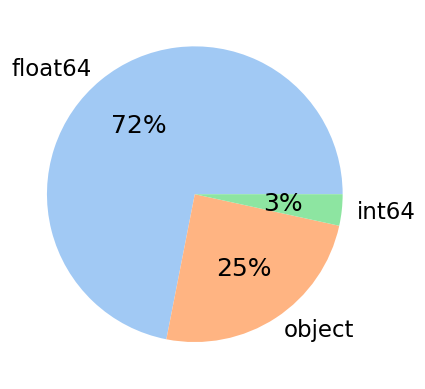

In [ ]:
print("Shape of our Dataframe, rows & columns: ", df.shape, "\n\r")
count_result = df.dtypes.value_counts() #we might have a fair amount of ints, floats and objects
print("Types of DataTypes within the DataFrame: ", count_result.size, "\n\r")
print("DISTRIBUTION AS FOLLOWS: ", "\n\r")
import matplotlib.pyplot as plt # Invoke MatPlotLib
import seaborn as sns # Invoke Seaborn
data = [count_result[0], count_result[1], count_result[2]] # Data
labels = [count_result.index[0], count_result.index[1], count_result.index[2]] # DataTypes
colors = sns.color_palette("pastel") # Look & Feel
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5}) # Font
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%') # PIE
plt.show() # Plot

Look for columns with a lot of NaN values, or as I call them, Ghost Features. I choose 50%. If we look closely, those features include member_id, inquiries, settlement data. That information is non-public or non mandatory so it is fair to take them out for this purpose. In a few words take tha noise out.

Total number of columns:  147 

Given the threshold 50  % NaN allowed, the total count of exceeding records is: 

dict_keys(['Yes', 'no'])  with the following counts:  dict_values([44, 103]) 

CHART - HOW MANY RECORDS EXCEED NAN % THRESHOLD 



<Axes: xlabel='exceeded', ylabel='Count'>

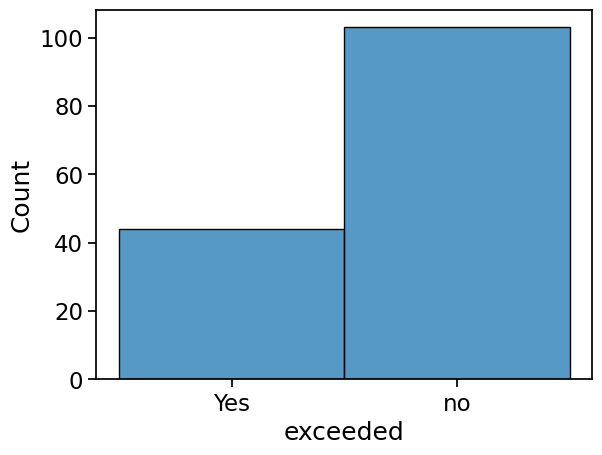

In [ ]:
from collections import Counter # Easy way to count

nanthreshold = 50 # % allowance limit of NaNs per column
missingseries = df.isna().mean().round(4)*100 # Series of % NaN per column
missingdf = pd.DataFrame(
    {'features': missingseries.keys(), 
     'percent':missingseries.values}) # Turn series to dataframe first
# Lets use lambda here (similar to if-then condition)
missingdf['exceeded'] = missingdf['percent'].apply(
    lambda x: 'Yes' if x >= nanthreshold else 'no') # quick classification

print("Total number of columns: ", len(missingdf['exceeded']),"\n\r")
print("Given the threshold", nanthreshold, " % NaN allowed, the total count of exceeding records is:","\n\r")
print(Counter(missingdf['exceeded']).keys(),
      " with the following counts: ",
      Counter(missingdf['exceeded']).values(),"\n\r")

print("CHART - HOW MANY RECORDS EXCEED NAN % THRESHOLD","\n\r")
sns.histplot(data=missingdf, x="exceeded", binwidth=3)

Totally empty features have something in common with columns with just 1 value in every row. Again, take the noise out.

In [ ]:
uniquedf = df.apply(pd.Series.nunique) # get unique value columns
singledf = uniquedf[uniquedf == 1].index.tolist() # list them
print("One-Value-Features: ", singledf)

One-Value-Features:  ['policy_code', 'hardship_type', 'deferral_term', 'hardship_length']


# Data wrangling

## Haircut

Take out the following: 1) Columns with too many NaNs 2) One-Value-Only Features 3) List of variables not likely to be present during the negotiation session. For the last one, there is no other way than: Walk the process step by step and ask a Subject Matter Expert or Super User of the Process. In the end, fundamental analysis matters. For the case-by-case analysis please follow the next link: https://github.com/coyoacan/abc/blob/13d72313eaaeebab936a7de47c5f17faceb6fefa/DefaultPrediction_FeatureReview.txt

In [ ]:
columns_to_drop = list(missingseries[missingseries >= 85].index)
list_one_by_one = ['id', 'funded_amnt', 'funded_amnt_inv', 'grade', 'issue_d', 'issue_d_dtime', 'issue_d_dtime_year','pymnt_plan', 'delinq_2yrs', 'earliest_cr_line',
 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
 'last_credit_pull_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq',
 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 
 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd',  'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl',
 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'hardship_flag',
 'debt_settlement_flag','open_acc_6m','open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',
       'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc','all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m','next_pymnt_d']
columns_to_drop = columns_to_drop + singledf + list_one_by_one
df = df.drop(columns_to_drop, axis=1)

Print the new distribution after removing features

NEW Shape of our Dataframe, rows & columns:  (2260668, 25) 

Types of DataTypes within the DataFrame:  3 

DISTRIBUTION AS FOLLOWS:  



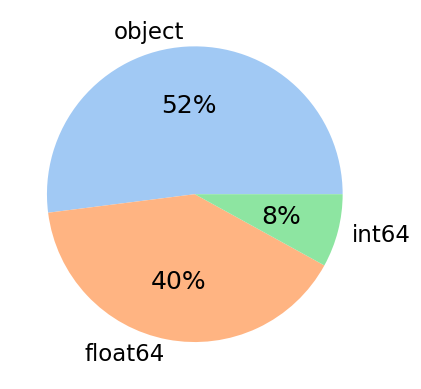

In [ ]:
print("NEW Shape of our Dataframe, rows & columns: ", df.shape, "\n\r")
count_result = df.dtypes.value_counts() #we might have a fair amount of ints, floats and objects
print("Types of DataTypes within the DataFrame: ", count_result.size, "\n\r")
print("DISTRIBUTION AS FOLLOWS: ", "\n\r")
data = [count_result[0], count_result[1], count_result[2]] # Data
labels = [count_result.index[0], count_result.index[1], count_result.index[2]] # DataTypes
colors = sns.color_palette("pastel") # Look & Feel
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5}) # Font
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%') # PIE
plt.show() # Plot

## Target variable

Out target row will be loan_status, we will only work with Fully Paid and Charged Off values. We need our Machine Learning model to find the "barrier" between these two outputs. Values: 'Current ', 'Late(31-120 days)', 'InGracePeriod', 'Late(16-30 days)' are ignored / discarded 

In [ ]:
df = df.loc[df['loan_status'].isin(['Fully Paid', 'Charged Off'])] #only rows with those values
print("By just selecting Fully Paid & Charged Off, we end up with the following shape: ", df.shape)

By just selecting Fully Paid & Charged Off, we end up with the following shape:  (1303607, 25)


The curse of an inbalanced data set 💔

Count of Charge Offs is->  261655
Count of Full Payments is->  1041952

---Let's visualize it graphically---



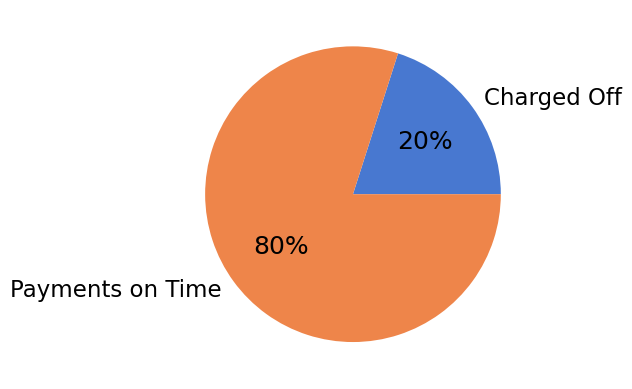

In [ ]:
count_co = df['loan_status'][df['loan_status'] == 'Charged Off'].count()
count_fp = df['loan_status'][df['loan_status'] == 'Fully Paid'].count()
print("Count of Charge Offs is-> ",
      count_co)
print("Count of Full Payments is-> ",
      count_fp)
print("\n\r---Let's visualize it graphically---\n\r")

#define data
data = [count_co, count_fp]
labels = ['Charged Off', 'Payments on Time']
#define Seaborn color palette to use
colors = sns.color_palette("muted")
#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

## Outliers

Looping through all numerical features and building a boxplot for each one we see some interesting things like annual income really above average. Given this, we are tempted to get rid of outliers, very high annual income or rev.balance. Outliers are part of UHNW clients or Premium Banking / Wealth Management, ergo, we cut those guys off

In [ ]:
print(df[["annual_inc","open_acc","revol_bal"]].describe().T)
df = df[df['annual_inc'] <= 200000] # Googled high income earners in US
df = df[df['open_acc'] <= 20] # Ever heard of a person opening 20 accounts?
df = df[df['revol_bal'] <= 200000] # Risk appetite may be around a year of income per client

                count          mean           std  min      25%      50%  \
annual_inc  1303607.0  76158.992119  70048.902587  0.0  45840.0  65000.0   
open_acc    1303607.0     11.592337      5.465282  0.0      8.0     11.0   
revol_bal   1303607.0  16235.987788  22286.291775  0.0   5952.0  11140.0   

                75%         max  
annual_inc  90000.0  10999200.0  
open_acc       14.0        90.0  
revol_bal   19748.0   2904836.0  


## Sampling

2,260,668 total records. Using: Calculator.net we estimate a sample size of 16,520. 99% Confidence Level, 1% Margin of Error, p=50% Population Proportion.

In [ ]:
df_group = df.groupby('loan_status').apply(lambda x: x.sample(n=16520)).reset_index(drop = True)
df_group.loan_status.value_counts()

Charged Off    16520
Fully Paid     16520
Name: loan_status, dtype: int64

Count of Charge Offs is->  16520
Count of Full Payments is->  16520

---Let's visualize it graphically---



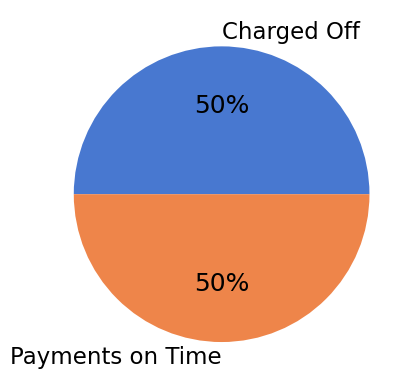

In [ ]:
count_co = df_group['loan_status'][df_group['loan_status'] == 'Charged Off'].count()
count_fp = df_group['loan_status'][df_group['loan_status'] == 'Fully Paid'].count()
print("Count of Charge Offs is-> ",
      count_co)
print("Count of Full Payments is-> ",
      count_fp)
print("\n\r---Let's visualize it graphically---\n\r")

#define data
data = [count_co, count_fp]
labels = ['Charged Off', 'Payments on Time']
#define Seaborn color palette to use
colors = sns.color_palette("muted")
#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

We would like to cast all object types into category. But first let us move the target feature to the last column and then do all that jazz

In [ ]:
new_cols = [col for col in df_group.columns if col != 'loan_status'] + ['loan_status']
df_group = df_group[new_cols] # new column order where target appears last
df_group = pd.concat([
        df_group.select_dtypes([], ['object']),
        df_group.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1)
df_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33040 entries, 0 to 33039
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   loan_amnt             33040 non-null  int64   
 1   int_rate              33040 non-null  float64 
 2   installment           33040 non-null  float64 
 3   annual_inc            33040 non-null  float64 
 4   dti                   33031 non-null  float64 
 5   open_acc              33040 non-null  float64 
 6   pub_rec               33040 non-null  float64 
 7   revol_bal             33040 non-null  int64   
 8   revol_util            33019 non-null  float64 
 9   total_acc             33040 non-null  float64 
 10  mort_acc              31855 non-null  float64 
 11  pub_rec_bankruptcies  33025 non-null  float64 
 12  term                  33040 non-null  category
 13  sub_grade             33040 non-null  category
 14  emp_title             30650 non-null  category
 15  em

# A little peek into feature importance

## Classes

See what is inside the sample, if there is a number describe its mean, count and std. If what is inside the sample is an object, describe the most common value, unique values and so on.

In [ ]:
df_group.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,33040.0,14392.796610,8461.412255,1000.00,8000.00,12000.00,20000.00,40000.00
int_rate,33040.0,14.191396,4.944517,5.31,10.91,13.66,17.14,30.99
installment,33040.0,434.811482,251.258040,21.62,255.30,375.49,568.60,1566.80
annual_inc,33040.0,68394.552180,34021.238381,0.00,44000.00,60000.00,85000.00,200000.00
dti,33031.0,18.749286,12.072171,0.00,12.23,18.15,24.67,999.00
open_acc,33040.0,10.663953,4.080740,1.00,8.00,10.00,13.00,20.00
pub_rec,33040.0,0.224970,0.578759,0.00,0.00,0.00,0.00,14.00
revol_bal,33040.0,14293.472034,14600.254628,0.00,5689.00,10512.00,18165.25,199157.00
revol_util,33019.0,53.508138,24.366464,0.00,35.45,54.10,72.30,155.30
total_acc,33040.0,23.279419,10.589422,2.00,16.00,22.00,30.00,94.00


In [ ]:
df_group.describe(include='category').T

,count,unique,top,freq
term,33040,2,36 months,23359
sub_grade,33040,35,C1,2097
emp_title,30650,17080,Teacher,527
emp_length,30801,11,10+ years,10528
home_ownership,33040,5,MORTGAGE,15232
verification_status,33040,3,Source Verified,12954
purpose,33040,14,debt_consolidation,19794
title,32559,2605,Debt consolidation,16746
zip_code,33040,859,945xx,358
addr_state,33040,50,CA,4876


In [ ]:
df_group.columns

Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc',
       'pub_rec_bankruptcies', 'term', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'purpose', 'title', 'zip_code',
       'addr_state', 'application_type', 'disbursement_method', 'loan_status'],
      dtype='object')

## Libraries for data pre-processing & code

I'm not going to spend too much time here, just a few comments on the following code. Pipelines need information in numbers,  for target variables we use LabelEncoder and for features we use OneHotEncoder (many columns 1 or 0) or OrdinalEncoder (same columns different num values). We also need imputers for missing values; those can be frequent values, mean, mode, et al. Feel free to experiment here, I'm not your boss.

In [ ]:
from timeit import default_timer # measure processing time :)
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot # Plot Features
from matplotlib.pyplot import figure # Look & Feel

### Making a pipeLine (this helps us speed things up)

In [ ]:
X = df_group.drop('loan_status',axis=1)
y = df_group['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=2022)

attributes_number = Pipeline(steps=[
    ('null_replacement', SimpleImputer(strategy='mean')),
    ('scaling', StandardScaler())
])

attributes_category = Pipeline(steps=[
    ('null_replacement', SimpleImputer(strategy='most_frequent')),
    ('encoding', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = -1))
])

columns_number = X_train.select_dtypes(include='number').columns.to_list()
columns_category = X_train.select_dtypes(include='category').columns.to_list()

attributes_preprocess = ColumnTransformer(transformers=[
    ('number', attributes_number, columns_number),
    ('category', attributes_category, columns_category)
])

label_encoding = LabelEncoder()
y_train = label_encoding.fit_transform(y_train)
y_test = label_encoding.fit_transform(y_test)

In [ ]:
import collections

In [ ]:
counter = collections.Counter(y_train)
counter


Counter({0: 11542, 1: 11586})

In [ ]:
counter = collections.Counter(y_test)
counter

Counter({1: 4934, 0: 4978})

## Many ways to look at feature importance

According to Jason Brownlee PhD "Feature importance refers to techniques that assign a score to input features based on how useful they are at predicting a target variable.There are many types and sources of feature importance scores, although popular examples include statistical correlation scores, coefficients calculated as part of linear models, decision trees, and permutation importance scores. Feature importance scores play an important role in a predictive modeling project, including providing insight into the data, insight into the model, and the basis for dimensionality reduction and feature selection that can improve the efficiency and effectiveness of a predictive model on the problem" (How to Calculate Feature Importance With Python, 2020, https://machinelearningmastery.com/calculate-feature-importance-with-python/)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from xgboost import XGBRegressor

### Linear Regression Feature Importance

Feature: 0, Score: 0.01044
Feature: 1, Score: 0.02157
Feature: 2, Score: -0.02839
Feature: 3, Score: 0.03032
Feature: 4, Score: -0.01783
Feature: 5, Score: -0.03075
Feature: 6, Score: -0.00733
Feature: 7, Score: 0.01565
Feature: 8, Score: -0.01577
Feature: 9, Score: 0.01009
Feature: 10, Score: 0.02569
Feature: 11, Score: 0.00106
Feature: 12, Score: -0.13798
Feature: 13, Score: -0.01923
Feature: 14, Score: -0.00001
Feature: 15, Score: -0.00103
Feature: 16, Score: -0.02574
Feature: 17, Score: -0.02111
Feature: 18, Score: -0.00364
Feature: 19, Score: 0.00002
Feature: 20, Score: 0.00003
Feature: 21, Score: 0.00013
Feature: 22, Score: -0.01663
Feature: 23, Score: -0.00543


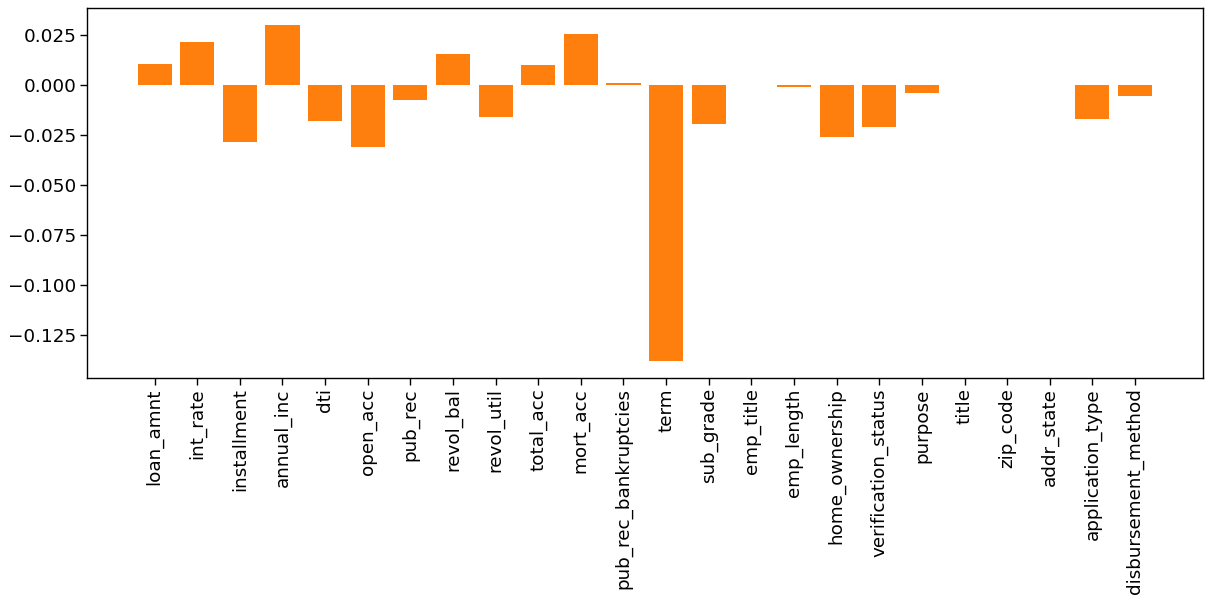

In [ ]:
# Linear Regression Feature Importance
model_pipeline = Pipeline(steps=[
    ('preprocess', attributes_preprocess),
    ('model', LinearRegression())
])

model_pipeline.fit(X_train, y_train)
importance = model_pipeline['model'].coef_

figure(figsize=(18, 6), dpi=80)

# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.bar(X_train.columns, importance)
pyplot.xticks(rotation=90)
pyplot.show()


### Logistic Regression Feature Importance

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Feature: 0, Score: -0.07934
Feature: 1, Score: -0.13987
Feature: 2, Score: -0.01965
Feature: 3, Score: 0.16198
Feature: 4, Score: -0.14910
Feature: 5, Score: -0.07516
Feature: 6, Score: -0.01147
Feature: 7, Score: 0.06777
Feature: 8, Score: -0.03566
Feature: 9, Score: 0.02852
Feature: 10, Score: 0.19461
Feature: 11, Score: -0.00508
Feature: 12, Score: -0.09706
Feature: 13, Score: -0.05989
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00289
Feature: 16, Score: -0.01092
Feature: 17, Score: -0.02266
Feature: 18, Score: 0.01876
Feature: 19, Score: 0.00029
Feature: 20, Score: 0.00054
Feature: 21, Score: 0.00740
Feature: 22, Score: -0.00491
Feature: 23, Score: 0.00005


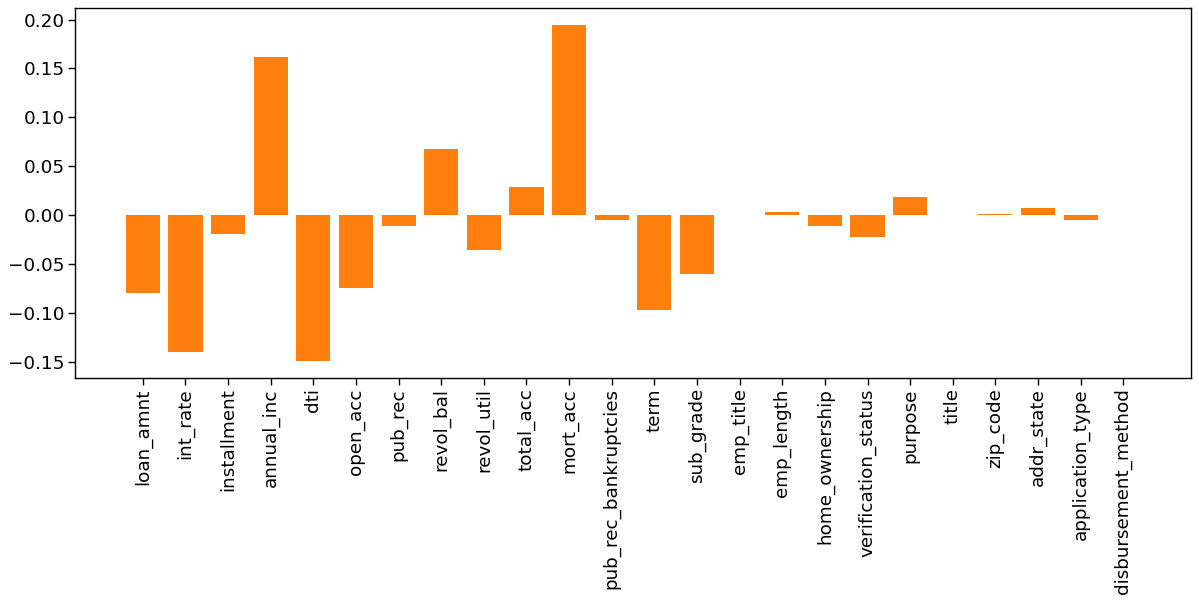

In [ ]:
# Logistic Regression Feature Importance
model_pipeline = Pipeline(steps=[
    ('preprocess', attributes_preprocess),
    ('model', LogisticRegression())
])

model_pipeline.fit(X_train, y_train)
importance = model_pipeline['model'].coef_[0] # this [0] is super important

figure(figsize=(18, 6), dpi=80)

# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.bar(X_train.columns, importance)
pyplot.xticks(rotation=90)
pyplot.show()

### Decision Tree Regressor

Feature: 0, Score: 0.03137
Feature: 1, Score: 0.06034
Feature: 2, Score: 0.05820
Feature: 3, Score: 0.06165
Feature: 4, Score: 0.07501
Feature: 5, Score: 0.04277
Feature: 6, Score: 0.00796
Feature: 7, Score: 0.07305
Feature: 8, Score: 0.06763
Feature: 9, Score: 0.05853
Feature: 10, Score: 0.02393
Feature: 11, Score: 0.00531
Feature: 12, Score: 0.01595
Feature: 13, Score: 0.11479
Feature: 14, Score: 0.08297
Feature: 15, Score: 0.03202
Feature: 16, Score: 0.01292
Feature: 17, Score: 0.01338
Feature: 18, Score: 0.01978
Feature: 19, Score: 0.02940
Feature: 20, Score: 0.06759
Feature: 21, Score: 0.04271
Feature: 22, Score: 0.00223
Feature: 23, Score: 0.00049


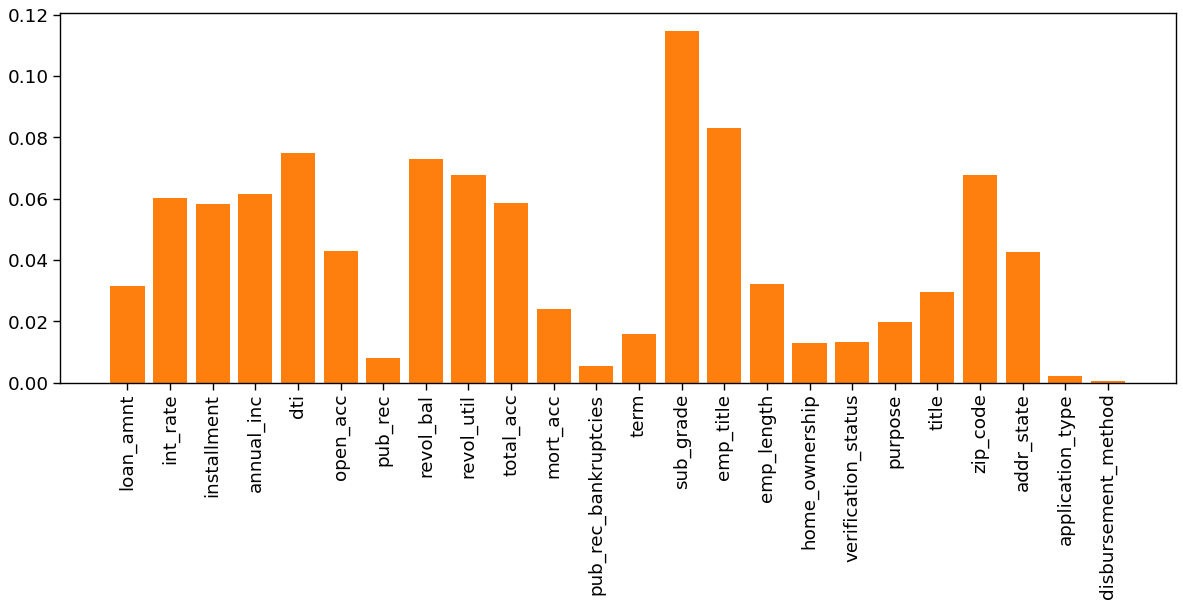

In [ ]:
# Decision Tree Regressor Feature Importance
model_pipeline = Pipeline(steps=[
    ('preprocess', attributes_preprocess),
    ('model', DecisionTreeRegressor())
])

model_pipeline.fit(X_train, y_train)
importance = model_pipeline['model'].feature_importances_ 
figure(figsize=(18, 6), dpi=80)

# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.bar(X_train.columns, importance)
pyplot.xticks(rotation=90)
pyplot.show()

### Decision Tree Classifier

Feature: 0, Score: 0.03251
Feature: 1, Score: 0.06223
Feature: 2, Score: 0.05782
Feature: 3, Score: 0.06190
Feature: 4, Score: 0.07400
Feature: 5, Score: 0.04322
Feature: 6, Score: 0.00871
Feature: 7, Score: 0.07395
Feature: 8, Score: 0.07065
Feature: 9, Score: 0.05449
Feature: 10, Score: 0.02539
Feature: 11, Score: 0.00544
Feature: 12, Score: 0.01575
Feature: 13, Score: 0.11289
Feature: 14, Score: 0.08374
Feature: 15, Score: 0.03196
Feature: 16, Score: 0.01234
Feature: 17, Score: 0.01308
Feature: 18, Score: 0.01974
Feature: 19, Score: 0.02691
Feature: 20, Score: 0.06820
Feature: 21, Score: 0.04190
Feature: 22, Score: 0.00269
Feature: 23, Score: 0.00050


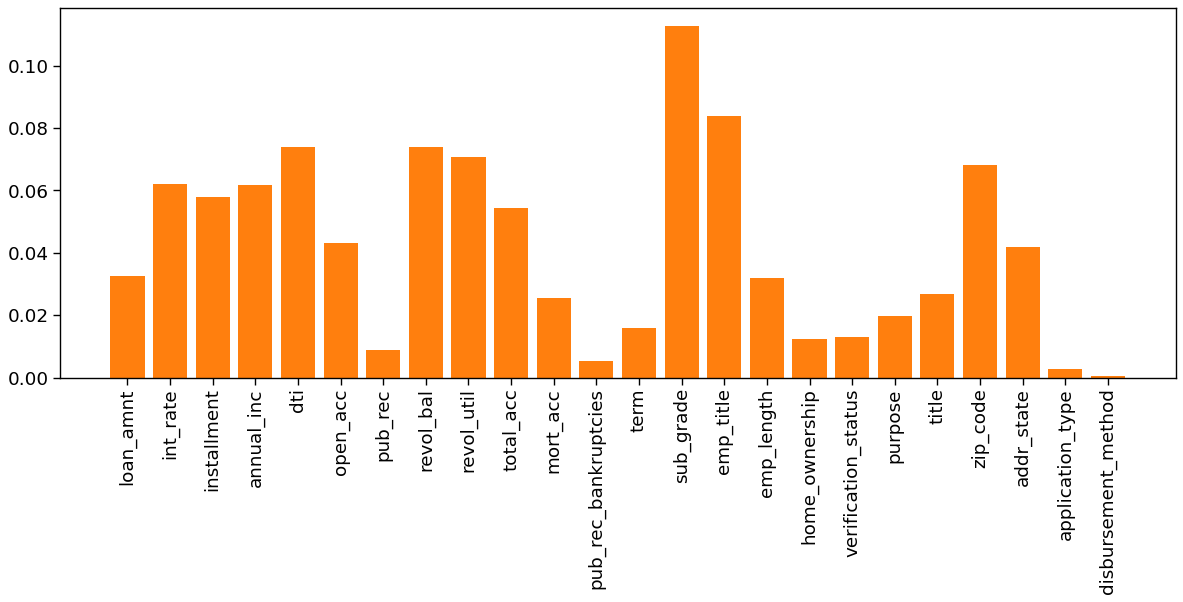

In [ ]:
# Decision Tree Classifier Feature Importance
model_pipeline = Pipeline(steps=[
    ('preprocess', attributes_preprocess),
    ('model', DecisionTreeClassifier())
])

model_pipeline.fit(X_train, y_train)
importance = model_pipeline['model'].feature_importances_ 
figure(figsize=(18, 6), dpi=80)

# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.bar(X_train.columns, importance)
pyplot.xticks(rotation=90)
pyplot.show()

### XGBoost Classifier

Feature: 0, Score: 0.02520
Feature: 1, Score: 0.03009
Feature: 2, Score: 0.02873
Feature: 3, Score: 0.02931
Feature: 4, Score: 0.02916
Feature: 5, Score: 0.02377
Feature: 6, Score: 0.02896
Feature: 7, Score: 0.02594
Feature: 8, Score: 0.02465
Feature: 9, Score: 0.02376
Feature: 10, Score: 0.03700
Feature: 11, Score: 0.02337
Feature: 12, Score: 0.15073
Feature: 13, Score: 0.25669
Feature: 14, Score: 0.02747
Feature: 15, Score: 0.02655
Feature: 16, Score: 0.03491
Feature: 17, Score: 0.03054
Feature: 18, Score: 0.02898
Feature: 19, Score: 0.02907
Feature: 20, Score: 0.02528
Feature: 21, Score: 0.02665
Feature: 22, Score: 0.03318
Feature: 23, Score: 0.00000


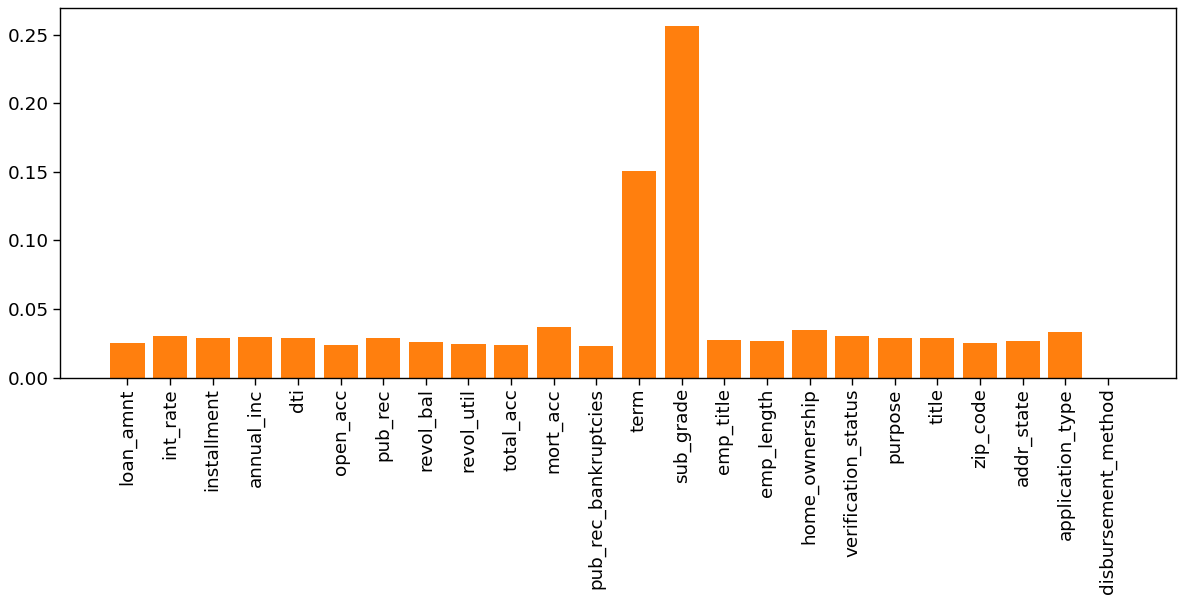

In [ ]:
# XGBoost Classifier Feature Importance
model_pipeline = Pipeline(steps=[
    ('preprocess', attributes_preprocess),
    ('model', XGBClassifier())
])

model_pipeline.fit(X_train, y_train)
importance = model_pipeline['model'].feature_importances_ 
figure(figsize=(18, 6), dpi=80)

# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.bar(X_train.columns, importance)
pyplot.xticks(rotation=90)
pyplot.show()

### XGBoost Regressor

Feature: 0, Score: 0.01351
Feature: 1, Score: 0.02101
Feature: 2, Score: 0.02734
Feature: 3, Score: 0.02603
Feature: 4, Score: 0.02760
Feature: 5, Score: 0.02192
Feature: 6, Score: 0.02255
Feature: 7, Score: 0.02607
Feature: 8, Score: 0.02504
Feature: 9, Score: 0.02454
Feature: 10, Score: 0.03734
Feature: 11, Score: 0.02644
Feature: 12, Score: 0.13019
Feature: 13, Score: 0.28524
Feature: 14, Score: 0.02874
Feature: 15, Score: 0.02552
Feature: 16, Score: 0.04184
Feature: 17, Score: 0.03235
Feature: 18, Score: 0.02686
Feature: 19, Score: 0.02748
Feature: 20, Score: 0.02633
Feature: 21, Score: 0.02718
Feature: 22, Score: 0.02474
Feature: 23, Score: 0.02416


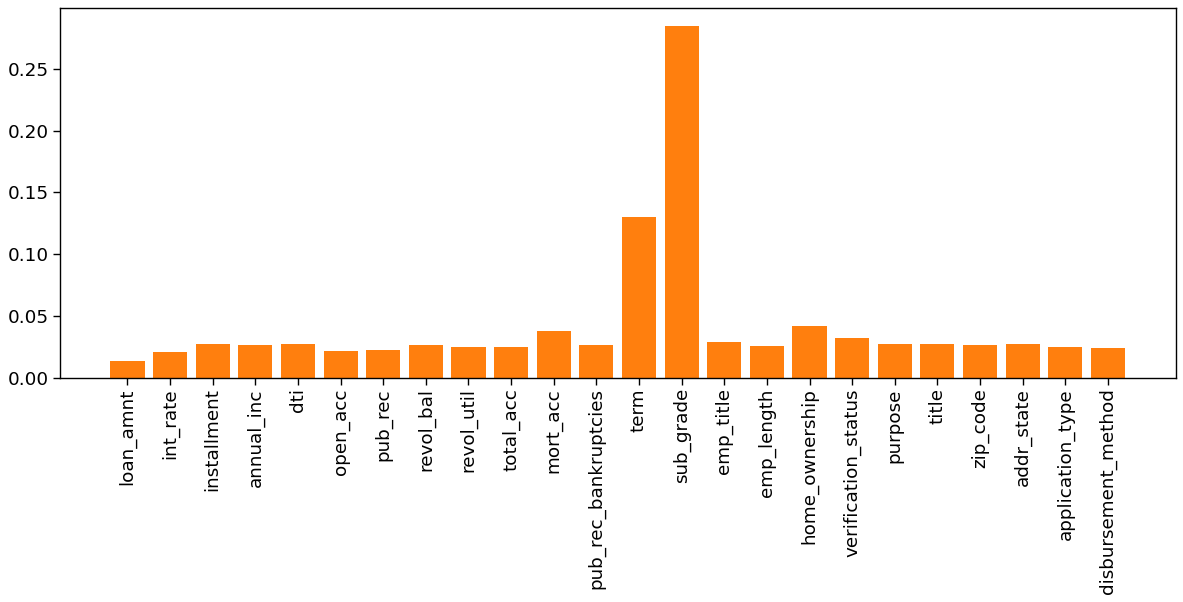

In [ ]:
# XGBoost Regressor Feature Importance
model_pipeline = Pipeline(steps=[
    ('preprocess', attributes_preprocess),
    ('model', XGBRegressor())
])

model_pipeline.fit(X_train, y_train)
importance = model_pipeline['model'].feature_importances_ 
figure(figsize=(18, 6), dpi=80)

# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.bar(X_train.columns, importance)
pyplot.xticks(rotation=90)
pyplot.show()

Fine, seems there is no solid consensus between previous approaches. Nevertheless, features such as grade, term, dti, loan amount always stand out, sounds logical to focus on them

# Modeling

## GridSearch Decision Tree Classifier

In [ ]:
from sklearn.model_selection import GridSearchCV # Before all the jazz

In [ ]:
model_pipeline = Pipeline(steps=[
                                 ('preprocesss', attributes_preprocess),
                                 ('model', DecisionTreeClassifier())                                 
]) 
#hace las combinaciones de los parámetros
#de manera interna Grid Search hacer todas las combinaciones
#Me dice cuál es la mejor combinación de hiperparámetros
#Se concatena model__ (model guión guión) porque se usa pipeline
#De no usarse un pipeline no se debe concatenar
params = [{
    'model__criterion':['gini','entropy','log_loss'],
    'model__max_depth':[5,7],    
}]

gs = GridSearchCV(model_pipeline, param_grid = params, scoring ='accuracy',cv=3,n_jobs =-1,verbose = 2)

In [ ]:
model_pipeline['model'].get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [ ]:
gs.fit(X_train,y_train)
gs.best_params_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


{'model__criterion': 'entropy', 'model__max_depth': 5}

In [ ]:
# imprimir la mejor evaluación
gs.best_score_

0.6420358021968248

In [ ]:
# obtener el mejor modelo
best_model = gs.best_estimator_

In [ ]:
y_pred = best_model.predict(X_test)

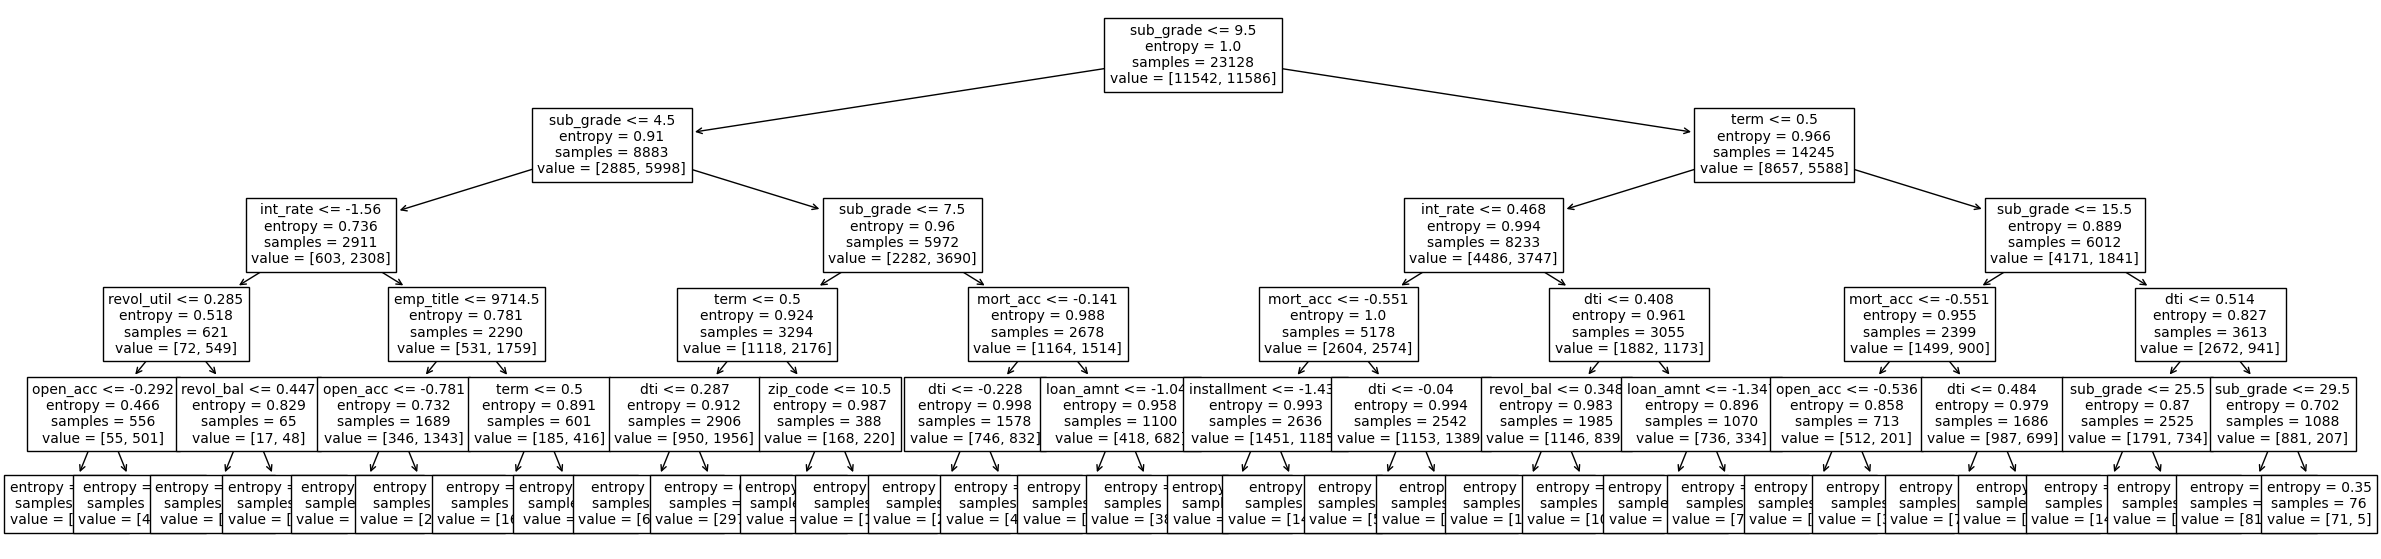

In [ ]:
from matplotlib.pylab import rcParams
from sklearn.tree import plot_tree, export_text
import matplotlib.pyplot as plt

rcParams['figure.figsize'] = 30,7

plot_tree(best_model['model'], feature_names=X_train.columns, fontsize= 10)
plt.show()

In [ ]:
print("mean accuracy (train): ", best_model.score(X_train,y_train))
print("mean accuracy (test): ", best_model.score(X_test,y_test))

mean accuracy (train):  0.6481753718436527
mean accuracy (test):  0.6376109765940274


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.62      0.72      0.67      4978
           1       0.66      0.55      0.60      4934

    accuracy                           0.64      9912
   macro avg       0.64      0.64      0.63      9912
weighted avg       0.64      0.64      0.64      9912



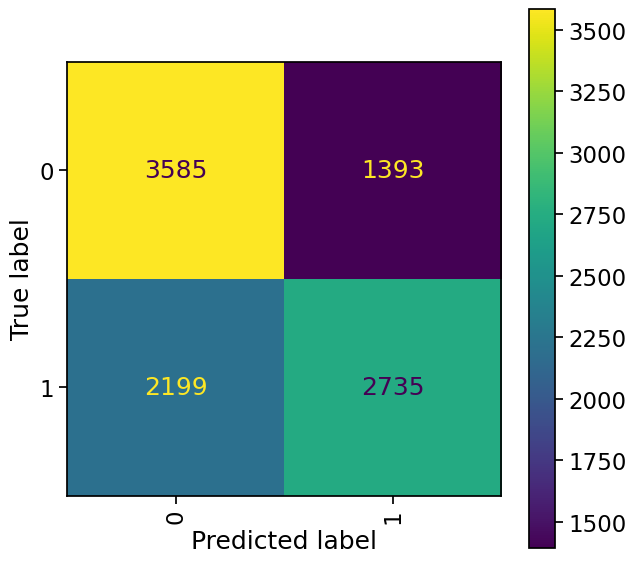

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

rcParams['figure.figsize'] = 7,7

ConfusionMatrixDisplay.from_predictions(y_test,y_pred, xticks_rotation='vertical')

plt.show()

## GridSearch Logistic Regression

In [ ]:
model_pipeline = Pipeline(steps=[
                                 ('preprocesss', attributes_preprocess),
                                 ('model', LogisticRegression())                                 
]) 
params = [{
    'model__C':[0.01,1],    
}]

gs = GridSearchCV(model_pipeline, param_grid = params, scoring ='accuracy',cv=3,n_jobs =-1,verbose = 2)

In [ ]:
model_pipeline['model'].get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [ ]:
gs.fit(X_train,y_train)
gs.best_params_

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'model__C': 1}

In [ ]:
# imprimir la mejor evaluación
gs.best_score_

0.6372364752749395

mean accuracy (train):  0.6393548945001729
mean accuracy (test):  0.6368038740920097
              precision    recall  f1-score   support

           0       0.63      0.67      0.65      4978
           1       0.64      0.61      0.62      4934

    accuracy                           0.64      9912
   macro avg       0.64      0.64      0.64      9912
weighted avg       0.64      0.64      0.64      9912



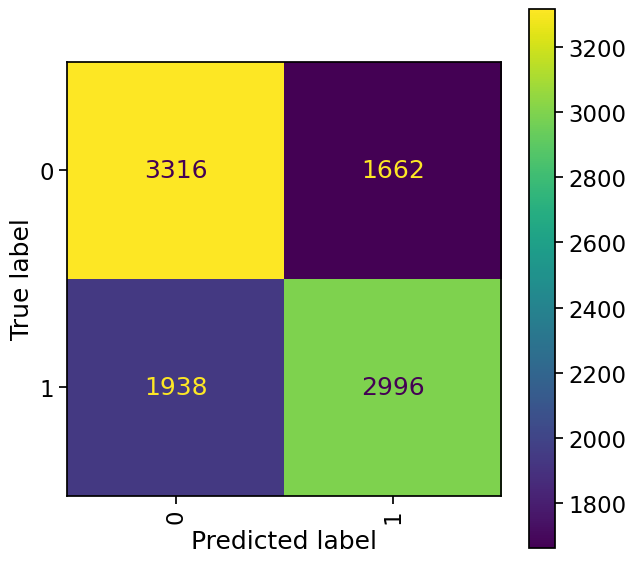

In [ ]:
# obtener el mejor modelo y su matriz de confusión
best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)
print("mean accuracy (train): ", best_model.score(X_train,y_train))
print("mean accuracy (test): ", best_model.score(X_test,y_test))
print(classification_report(y_test,y_pred))

rcParams['figure.figsize'] = 7,7

ConfusionMatrixDisplay.from_predictions(y_test,y_pred, xticks_rotation='vertical')

plt.show()

# Conclusions

## Sensitivity vs Specificity (ROC curve)

Receiver Operating Characteristic (ROC) & Area Under the Curve (AUC) A plot between Sensitivity & Specificity For more information: https://r.search.yahoo.com/_ylt=AwrFDYrCXA9kciQHTFjD8Qt.;_ylu=Y29sbwNiZjEEcG9zAzUEdnRpZAMEc2VjA3Ny/RV=2/RE=1678757187/RO=10/RU=https%3a%2f%2fwww.cambridge.org%2fcore%2fservices%2faop-cambridge-core%2fcontent%2fview%2fS1481803500013336/RK=2/RS=KGJl9TiboQzoHkKXBvgbj8xxU04-

In [ ]:
from sklearn import metrics
from sklearn.svm import SVC

The Next Piece of Code takes ~ 5 minutes to execute

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


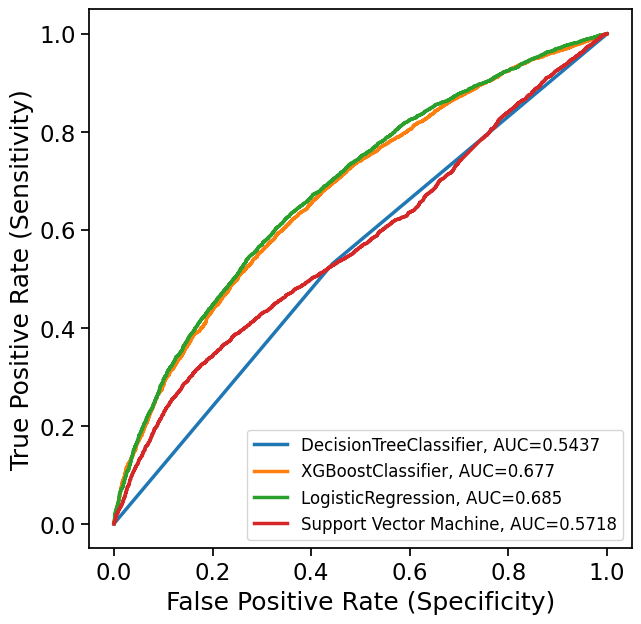

In [ ]:
#set up plotting area
plt.figure(0).clf()

# fit Decision Tree Classifier
model_pipeline = Pipeline(steps=[
                                 ('preprocesss', attributes_preprocess),
                                 ('model', DecisionTreeClassifier())                                 
])
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="DecisionTreeClassifier, AUC="+str(auc))

# fit XGBoost Classifier
model_pipeline = Pipeline(steps=[
                                 ('preprocesss', attributes_preprocess),
                                 ('model', XGBClassifier())                                 
])
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="XGBoostClassifier, AUC="+str(auc))

# fit Logistic Regression
model_pipeline = Pipeline(steps=[
                                 ('preprocesss', attributes_preprocess),
                                 ('model', LogisticRegression())                                 
])
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="LogisticRegression, AUC="+str(auc))

# fit Support Vector Machine
model_pipeline = Pipeline(steps=[
                                 ('preprocesss', attributes_preprocess),
                                 ('model', SVC(probability=True))                                 
])
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Support Vector Machine, AUC="+str(auc))

#add legend
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (Specificity)')
plt.legend(loc=4,prop={'size': 12})

## Closing Arguments & Findings

With a given ROC curve we can see `XGBoost Classifier` and `Logistic Regression` are two best choices to predict credit default from our testing. Nevertheless a ~0.60 AUC is not as good as it should be. More features are required.